## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [44]:
import os
import keras
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [45]:
train, test = keras.datasets.cifar10.load_data()

In [46]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [47]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [48]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10):
    """Code Here
    建立你的神經網路
    """
    Input_layer=keras.layers.Input(input_shape)
    x=keras.layers.Dense(activation='relu',units=128)(Input_layer)
    x=BatchNormalization()(x)
    x=keras.layers.Dense(activation='relu',units=64)(x)
    out=keras.layers.Dense(activation='softmax',units=output_units)(x)
    model=keras.models.Model(inputs=[Input_layer],outputs=[out])
    return model

In [49]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [58]:
import tensorflow as tf
import keras.backend as K
import numpy as np
"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(ce_weight=0.7):
    """Define the customized loss."""
    
    def end_loss_function(y_true,y_pred):
        #focal loss
        gamma = float(2.)
        alpha = float(4.)
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        focal=tf.reduce_mean(reduced_fl)
        #crossentropy loss
        crossentropy=keras.losses.categorical_crossentropy(y_true, y_pred)
        
        end_loss=(1-ce_weight)*focal+ce_weight*crossentropy
        return end_loss
    return end_loss_function
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [59]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(ce_weight=ce_w), metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0728 00:11:29.669681 18380 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 128)               393344    
_________________________________________________________________
batch_normalization_21 (Batc (None, 128)               512       
_________________________________________________________________
dense_63 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_64 (Dense)             (None, 10)                650       
Total params: 402,762
Trainable params: 402,506
Non-trainable params: 256
_________________________________________________________________


W0728 00:11:29.976865 18380 deprecation.py:323] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 15s 305us/step - loss: 6.2476 - acc: 0.2877 - val_loss: 5.5322 - val_acc: 0.3379
Epoch 2/25
50000/50000 [==============================] - 3s 58us/step - loss: 4.9948 - acc: 0.3905 - val_loss: 5.1028 - val_acc: 0.3734
Epoch 3/25
50000/50000 [==============================] - 3s 56us/step - loss: 4.6445 - acc: 0.4213 - val_loss: 4.7417 - val_acc: 0.4066
Epoch 4/25
50000/50000 [==============================] - 3s 56us/step - loss: 4.4282 - acc: 0.4405 - val_loss: 4.4910 - val_acc: 0.4229
Epoch 5/25
50000/50000 [==============================] - 3s 62us/step - loss: 4.2603 - acc: 0.4559 - val_loss: 4.4707 - val_acc: 0.4234
Epoch 6/25
50000/50000 [==============================] - 3s 64us/step - loss: 4.1347 - acc: 0.4641 - val_loss: 4.4665 - val_acc: 0.4170
Epoch 7/25
50000/50000 [==============================] - 3s 67us/step - loss: 4.0185 - acc: 0.4774 - val_loss: 4.2750 - val_a

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 87us/step - loss: 4.0979 - acc: 0.2811 - val_loss: 3.8214 - val_acc: 0.3161
Epoch 2/25
50000/50000 [==============================] - 4s 71us/step - loss: 3.3774 - acc: 0.3865 - val_loss: 3.3432 - val_acc: 0.3892
Epoch 3/25
50000/50000 [==============================] - 4s 71us/step - loss: 3.1849 - acc: 0.4136 - val_loss: 3.2344 - val_acc: 0.3976
Epoch 4/25
50000/50000 [==============================] - 4s 74us/step - loss: 3.0611 - acc: 0.4335 - val_loss: 3.1215 - val_acc: 0.4173
Epoch 5/25
50000/50000 [==============================] - 4s 73us/step - loss: 2.9656 - acc: 0.4464 - val_loss: 3.0937 - val_acc: 0.4224
Epoch 6/25
50000/50000 [==============================] - 4s 71us/step - loss: 2.8905 - acc: 0.4599 - val_loss: 3.0454 - val_acc: 0.4297
Epoch 7/25
50000/50000 [==============================] - 4s 71us/step - loss: 2.8217 - acc: 0.4690 - val_loss: 2.9637 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 139us/step - loss: 2.2258 - acc: 0.2150 - val_loss: 2.0940 - val_acc: 0.2571
Epoch 2/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.8904 - acc: 0.3358 - val_loss: 1.8595 - val_acc: 0.3432
Epoch 3/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.8001 - acc: 0.3708 - val_loss: 1.7998 - val_acc: 0.3638
Epoch 4/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.7492 - acc: 0.3903 - val_loss: 1.7574 - val_acc: 0.3771
Epoch 5/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.7111 - acc: 0.4047 - val_loss: 1.7233 - val_acc: 0.3945
Epoch 6/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.6799 - acc: 0.4149 - val_loss: 1.7001 - val_acc: 0.4030
Epoch 7/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.6540 - acc: 0.4222 - val_loss: 1.6697 - 

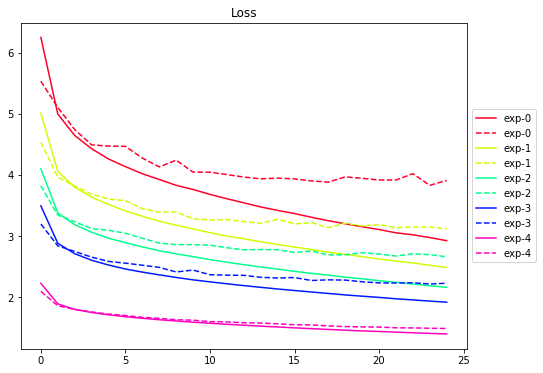

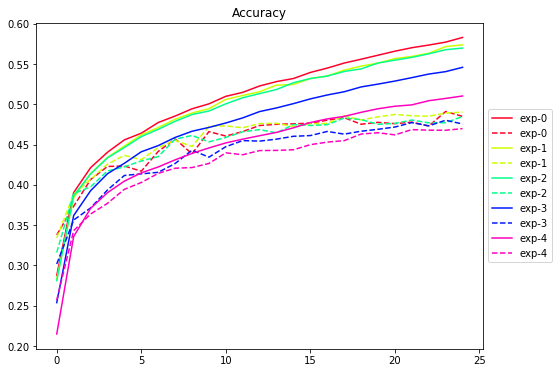

In [60]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()